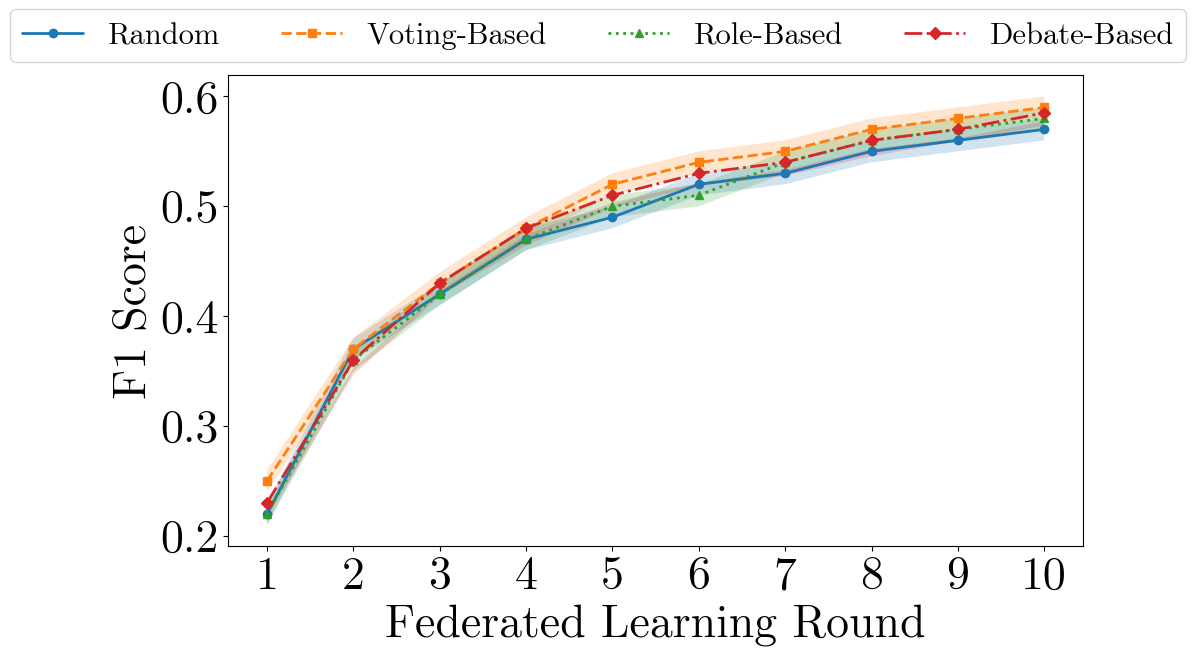

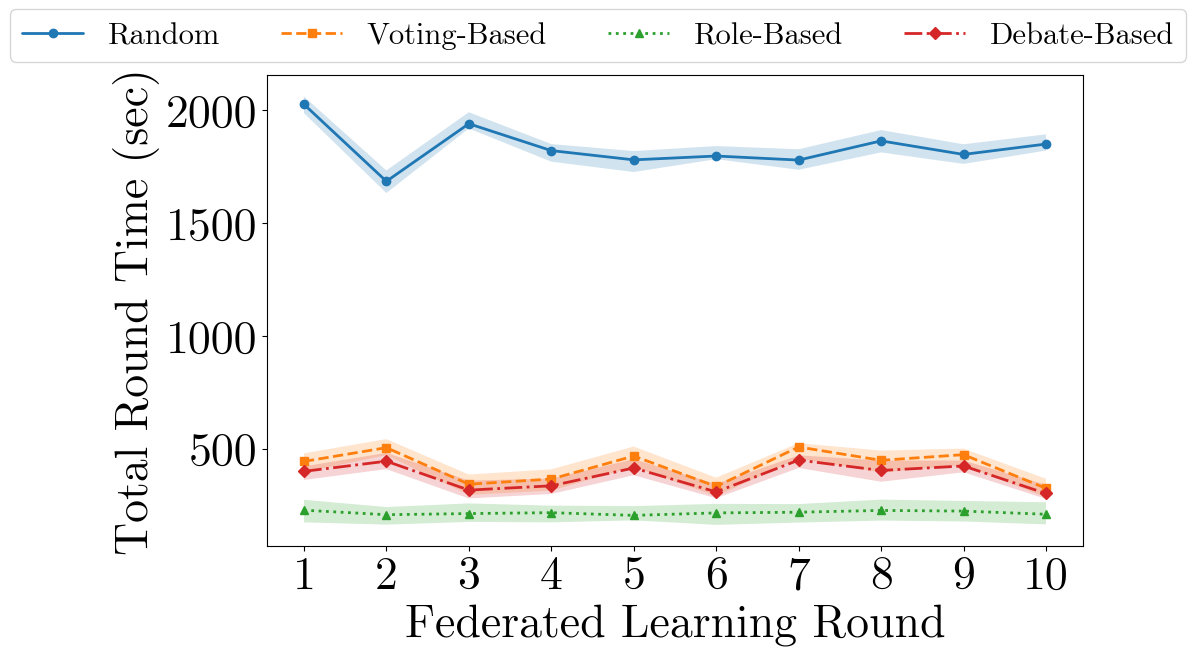

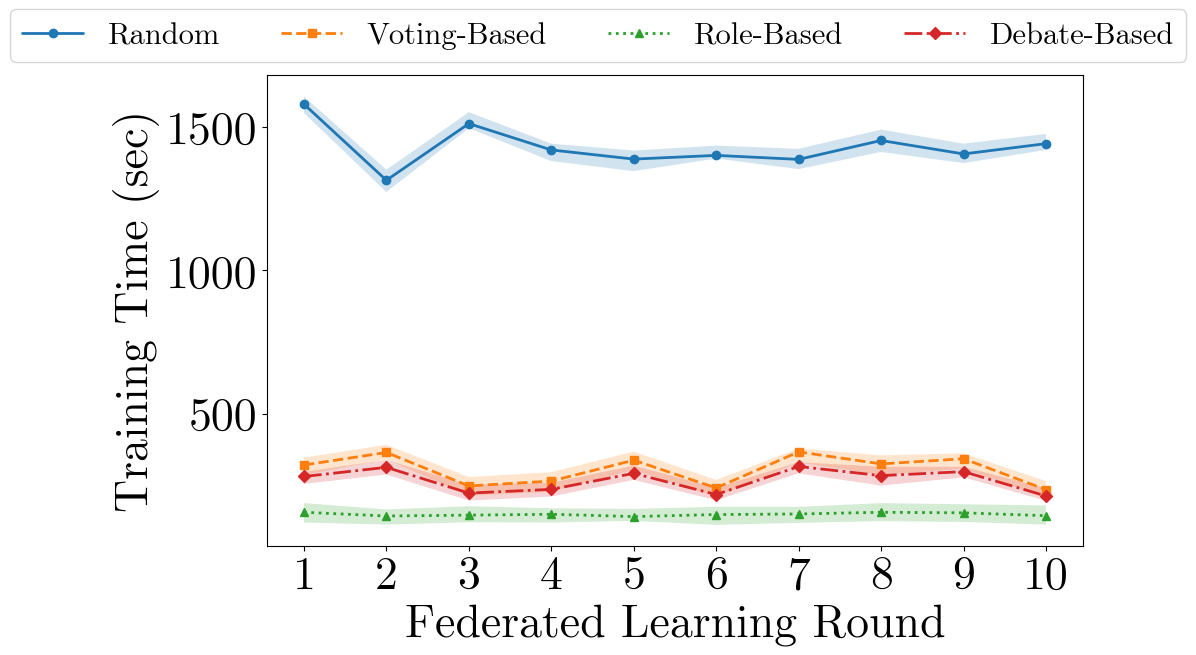

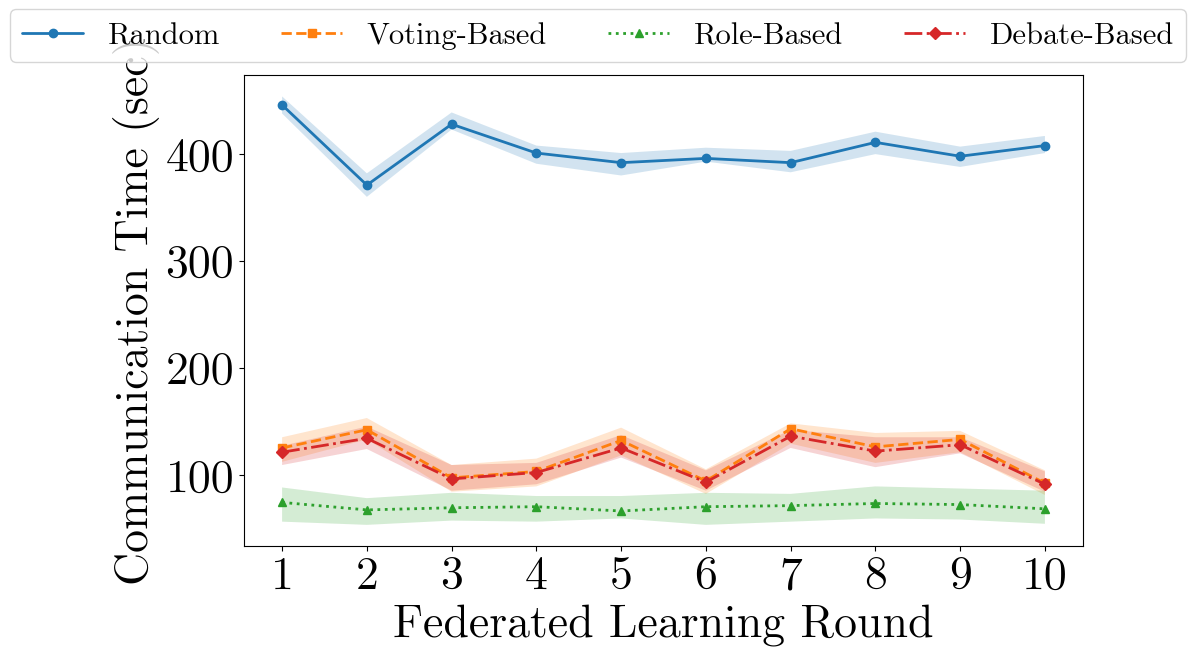

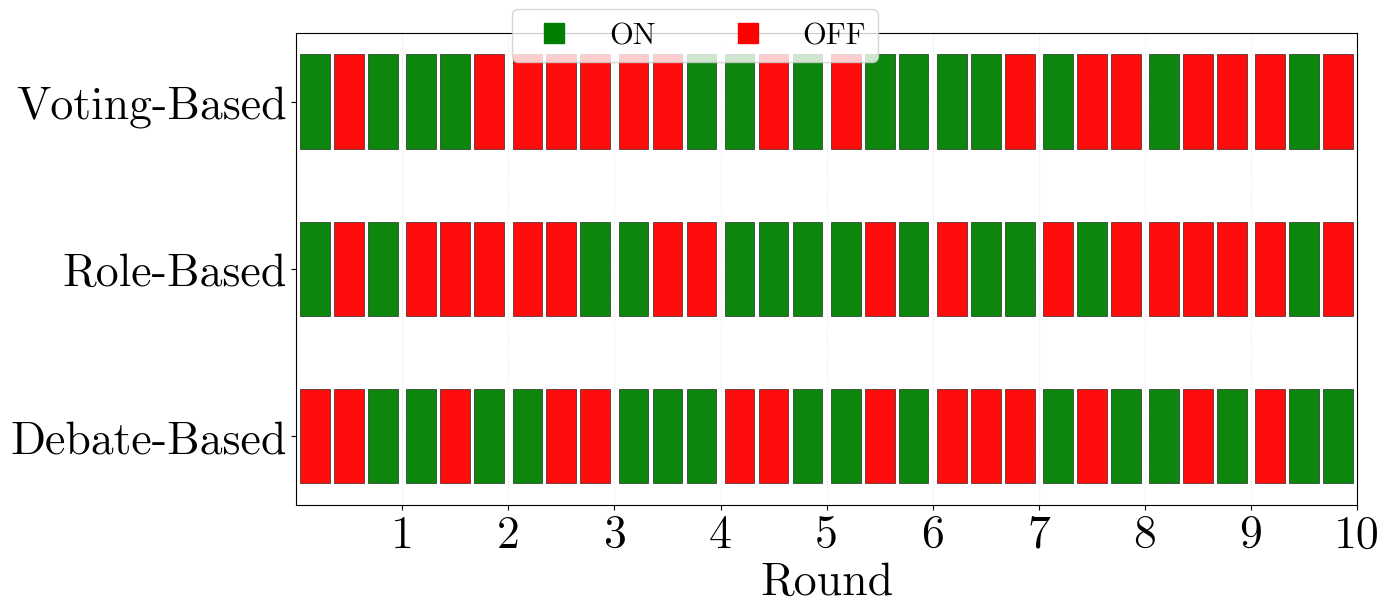

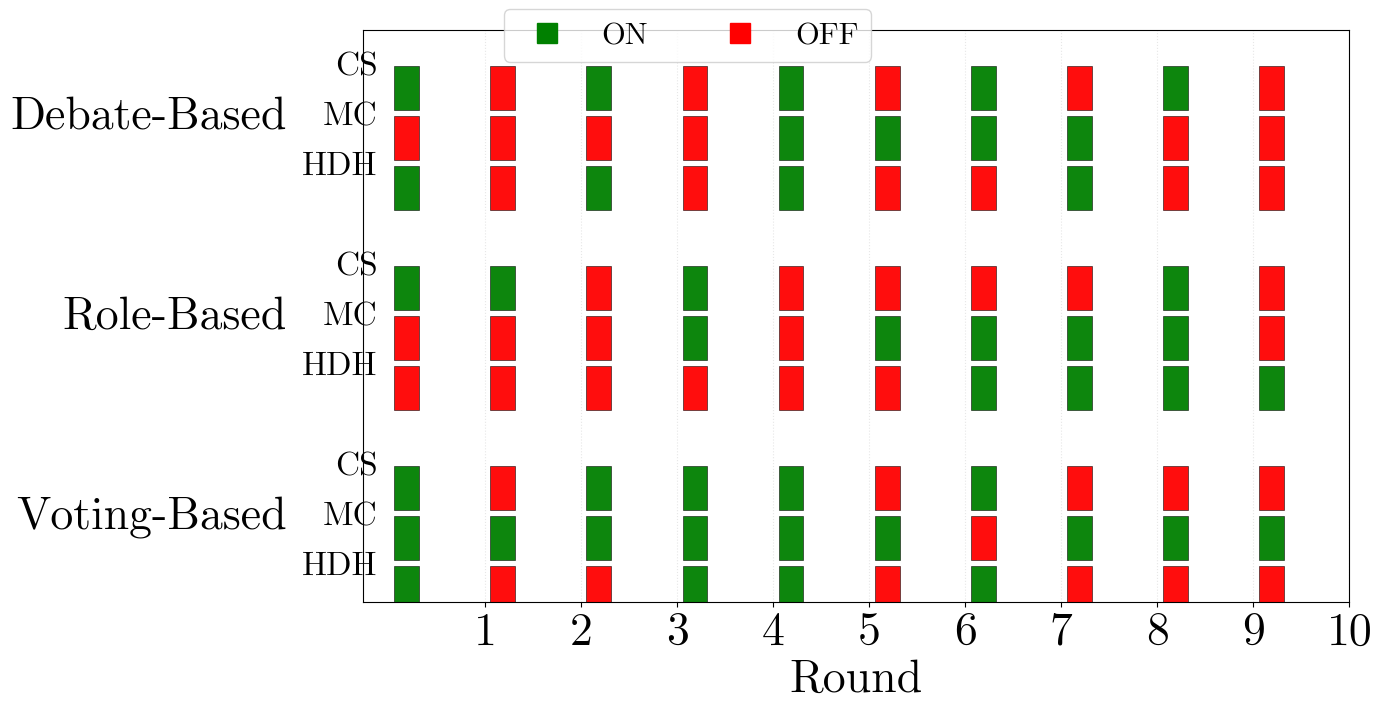

In [14]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'CMU Serif'

import matplotlib.pyplot as plt
import numpy as np

# Rounds
rounds = np.arange(1, 11)
FS = 33  # font size comodo e consistente
LEG_FS = 22

# ======= DATI ORIGINALI (riusati) =======
# F1 (Accuracy) per A, B, C
acc_A = [0.25, 0.37, 0.43, 0.48, 0.52, 0.54, 0.55, 0.57, 0.58, 0.59]
acc_B = [0.22, 0.37, 0.42, 0.47, 0.49, 0.52, 0.53, 0.55, 0.56, 0.57]
acc_C = [0.22, 0.36, 0.42, 0.47, 0.50, 0.51, 0.54, 0.56, 0.57, 0.58]

# Total Round Time per A, B, C (sec)
tot_A = [445, 506, 344, 367, 469, 334, 509, 450, 475, 326]
tot_B = [2027, 1686, 1941, 1822, 1781, 1798, 1780, 1865, 1805, 1851]
tot_C = [229, 209, 214, 218, 206, 217, 220, 228, 225, 211]

# Bande simulate per fill_between (Accuracy)
acc_sim_A = [
    [0.24,0.25,0.26,0.25,0.24,0.25,0.26,0.24,0.25,0.26],
    [0.36,0.37,0.38,0.37,0.36,0.37,0.38,0.36,0.37,0.38],
    [0.42,0.43,0.44,0.43,0.42,0.43,0.44,0.42,0.43,0.44],
    [0.47,0.48,0.49,0.48,0.47,0.48,0.49,0.47,0.48,0.49],
    [0.51,0.52,0.53,0.52,0.51,0.52,0.53,0.51,0.52,0.53],
    [0.53,0.54,0.55,0.54,0.53,0.54,0.55,0.53,0.54,0.55],
    [0.54,0.55,0.56,0.55,0.54,0.55,0.56,0.54,0.55,0.56],
    [0.56,0.57,0.58,0.57,0.56,0.57,0.58,0.56,0.57,0.58],
    [0.57,0.58,0.59,0.58,0.57,0.58,0.59,0.57,0.58,0.59],
    [0.58,0.59,0.60,0.59,0.58,0.59,0.60,0.58,0.59,0.60]
]
acc_sim_B = [
    [0.21,0.22,0.23,0.22,0.21,0.22,0.23,0.21,0.22,0.23],
    [0.36,0.37,0.38,0.37,0.36,0.37,0.38,0.36,0.37,0.38],
    [0.41,0.42,0.43,0.42,0.41,0.42,0.43,0.41,0.42,0.43],
    [0.46,0.47,0.48,0.47,0.46,0.47,0.48,0.46,0.47,0.48],
    [0.48,0.49,0.50,0.49,0.48,0.49,0.50,0.48,0.49,0.50],
    [0.51,0.52,0.53,0.52,0.51,0.52,0.53,0.51,0.52,0.53],
    [0.52,0.53,0.54,0.53,0.52,0.53,0.54,0.52,0.53,0.54],
    [0.54,0.55,0.56,0.55,0.54,0.55,0.56,0.54,0.55,0.56],
    [0.55,0.56,0.57,0.56,0.55,0.56,0.57,0.55,0.56,0.57],
    [0.56,0.57,0.58,0.57,0.56,0.57,0.58,0.56,0.57,0.58]
]
acc_sim_C = [
    [0.21,0.22,0.23,0.22,0.21,0.22,0.23,0.21,0.22,0.23],
    [0.35,0.36,0.37,0.36,0.35,0.36,0.37,0.35,0.36,0.37],
    [0.41,0.42,0.43,0.42,0.41,0.42,0.43,0.41,0.42,0.43],
    [0.46,0.47,0.48,0.47,0.46,0.47,0.48,0.46,0.47,0.48],
    [0.49,0.50,0.51,0.50,0.49,0.50,0.51,0.49,0.50,0.51],
    [0.50,0.51,0.52,0.51,0.50,0.51,0.52,0.50,0.51,0.52],
    [0.53,0.54,0.55,0.54,0.53,0.54,0.55,0.53,0.54,0.55],
    [0.55,0.56,0.57,0.56,0.55,0.56,0.57,0.55,0.56,0.57],
    [0.56,0.57,0.58,0.57,0.56,0.57,0.58,0.56,0.57,0.58],
    [0.57,0.58,0.59,0.58,0.57,0.58,0.59,0.57,0.58,0.59]
]

# Bande simulate per fill_between (Total Round Time)
time_sim_A = [
    [410,397,418,451,439,481,477,425,424,435],
    [510,482,520,494,508,495,486,544,531,473],
    [376,342,387,371,335,297,322,348,360,316],
    [323,400,410,366,336,345,316,407,324,368],
    [441,474,482,500,436,421,428,511,509,472],
    [340,350,305,373,327,323,332,291,299,352],
    [458,519,476,491,484,493,526,480,510,504],
    [461,493,471,418,396,418,455,399,448,450],
    [453,502,438,429,493,472,494,467,451,500],
    [349,345,301,331,314,286,362,288,368,313],
]
time_sim_B = [
    [1988,2031,2062,2051,2056,2038,2041,2058,2003,2028],
    [1652,1734,1733,1636,1707,1730,1653,1688,1725,1634],
    [1959,1920,1985,1992,1990,1939,1980,1982,1928,1981],
    [1773,1831,1796,1787,1784,1843,1811,1851,1782,1811],
    [1773,1810,1759,1789,1820,1787,1752,1727,1817,1735],
    [1827,1800,1835,1826,1842,1784,1821,1784,1793,1803],
    [1812,1828,1805,1769,1774,1806,1754,1737,1769,1755],
    [1839,1838,1816,1814,1909,1856,1856,1884,1837,1913],
    [1828,1763,1798,1845,1848,1802,1820,1768,1850,1776],
    [1894,1865,1863,1856,1825,1823,1829,1822,1885,1844],
]
time_sim_C = [
    [175,275,262,270,272,189,210,250,246,191],
    [236,181,179,213,220,216,171,243,180,165],
    [251,259,252,248,232,220,177,210,209,196],
    [237,217,175,188,237,177,249,221,211,220],
    [234,190,221,211,184,240,238,225,242,247],
    [235,250,237,237,225,241,178,249,257,164],
    [250,182,205,243,183,247,256,221,174,203],
    [236,276,239,202,242,233,251,183,248,225],
    [266,209,237,269,181,270,240,179,208,249],
    [166,219,197,224,168,253,262,264,241,182],
]

# ======= RINOMINA APPROCCI =======
# Random -> B ; Voting-Based -> A ; Role-Based -> C ; Debate-Based -> inventato (blend A/C)
approaches = ["Random", "Voting-Based", "Role-Based", "Debate-Based"]

F1 = {
    "Random":       acc_B,
    "Voting-Based": acc_A,
    "Role-Based":   acc_C,
    # inventato: intermedio tra A e C
    "Debate-Based": [0.23, 0.36, 0.43, 0.48, 0.51, 0.53, 0.54, 0.56, 0.57, 0.585],
}
F1_sim = {
    "Random":       acc_sim_B,
    "Voting-Based": acc_sim_A,
    "Role-Based":   acc_sim_C,
    # piccola varianza attorno alla serie inventata (nessun seed)
    "Debate-Based": [[max(0.20, v - 0.01) + 0.002*np.random.randn() for _ in range(10)]
                     for v in [0.23, 0.36, 0.43, 0.48, 0.51, 0.53, 0.54, 0.56, 0.57, 0.585]],
}

Total = {
    "Random":       tot_B,
    "Voting-Based": tot_A,
    "Role-Based":   tot_C,
    # blend 80% A + 20% C
    "Debate-Based": [int(0.8*a + 0.2*c) for a, c in zip(tot_A, tot_C)],
}
Total_sim = {
    "Random":       time_sim_B,
    "Voting-Based": time_sim_A,
    "Role-Based":   time_sim_C,
    "Debate-Based": [[int(0.8*aa + 0.2*cc) for aa, cc in zip(rowA, rowC)]
                     for rowA, rowC in zip(time_sim_A, time_sim_C)],
}

# ======= TRAINING/COMMUNICATION TIME (derivati da Total) =======
split = {"Random": 0.78, "Voting-Based": 0.72, "Role-Based": 0.68, "Debate-Based": 0.70}
Training = {k: [int(split[k]*t) for t in Total[k]] for k in approaches}
Comm     = {k: [tt - tr for tt, tr in zip(Total[k], Training[k])] for k in approaches}

Training_sim = {
    k: [[int(split[k]*val) for val in Total_sim[k][r]] for r in range(len(rounds))]
    for k in approaches
}
Comm_sim = {
    k: [[tt - tr for tt, tr in zip(Total_sim[k][r], Training_sim[k][r])] for r in range(len(rounds))]
    for k in approaches
}

# ======= PLOTTING =======
def band(two_d):
    lo = [min(v) for v in two_d]
    hi = [max(v) for v in two_d]
    return lo, hi

markers   = {"Random":"o","Voting-Based":"s","Role-Based":"^","Debate-Based":"D"}
linestyle = {"Random":"-","Voting-Based":"--","Role-Based":":","Debate-Based":"-."}

# F1
fig, ax = plt.subplots(figsize=(10, 6))
for k in approaches:
    ax.plot(rounds, F1[k], label=k, marker=markers[k], linewidth=2, linestyle=linestyle[k], solid_capstyle="round")
    lo, hi = band(F1_sim[k])
    ax.fill_between(rounds, lo, hi, alpha=0.2)
ax.set_xlabel("Federated Learning Round", fontsize=FS)
ax.set_ylabel("F1 Score", fontsize=FS)
ax.tick_params(axis="both", labelsize=FS)
ax.set_xticks(rounds)
fig.legend(fontsize=LEG_FS, loc="upper center", bbox_to_anchor=(0.5, 1.11), ncol=4)
plt.tight_layout()
plt.savefig("Coordination_F1.pdf", bbox_inches="tight")
plt.show()

# Total Round Time
fig, ax = plt.subplots(figsize=(10, 6))
for k in approaches:
    ax.plot(rounds, Total[k], label=k, marker=markers[k], linewidth=2, linestyle=linestyle[k], solid_capstyle="round")
    lo, hi = band(Total_sim[k])
    ax.fill_between(rounds, lo, hi, alpha=0.2)
ax.set_xlabel("Federated Learning Round", fontsize=FS)
ax.set_ylabel("Total Round Time (sec)", fontsize=FS)
ax.tick_params(axis="both", labelsize=FS)
ax.set_xticks(rounds)
fig.legend(fontsize=LEG_FS, loc="upper center", bbox_to_anchor=(0.5, 1.11), ncol=4)
plt.tight_layout()
plt.savefig("Coordination_TotalTime.pdf", bbox_inches="tight")
plt.show()

# Training Time
fig, ax = plt.subplots(figsize=(10, 6))
for k in approaches:
    ax.plot(rounds, Training[k], label=k, marker=markers[k], linewidth=2, linestyle=linestyle[k], solid_capstyle="round")
    lo, hi = band(Training_sim[k])
    ax.fill_between(rounds, lo, hi, alpha=0.2)
ax.set_xlabel("Federated Learning Round", fontsize=FS)
ax.set_ylabel("Training Time (sec)", fontsize=FS)
ax.tick_params(axis="both", labelsize=FS)
ax.set_xticks(rounds)
fig.legend(fontsize=LEG_FS, loc="upper center", bbox_to_anchor=(0.5, 1.11), ncol=4)
plt.tight_layout()
plt.savefig("Coordination_TrainingTime.pdf", bbox_inches="tight")
plt.show()

# Communication Time
fig, ax = plt.subplots(figsize=(10, 6))
for k in approaches:
    ax.plot(rounds, Comm[k], label=k, marker=markers[k], linewidth=2, linestyle=linestyle[k], solid_capstyle="round")
    lo, hi = band(Comm_sim[k])
    ax.fill_between(rounds, lo, hi, alpha=0.2)
ax.set_xlabel("Federated Learning Round", fontsize=FS)
ax.set_ylabel("Communication Time (sec)", fontsize=FS)
ax.tick_params(axis="both", labelsize=FS)
ax.set_xticks(rounds)
fig.legend(fontsize=LEG_FS, loc="upper center", bbox_to_anchor=(0.5, 1.11), ncol=4)
plt.tight_layout()
plt.savefig("Coordination_CommTime.pdf", bbox_inches="tight")
plt.show()


# === Pattern per approccio: y=3 istogrammi, x=rounds; ogni round ha 3 parti (CS, MC, HDH) ===
if 'FS' not in globals(): FS = 33
if 'LEG_FS' not in globals(): LEG_FS = 22

# usa 'rounds' già definito sopra se esiste, altrimenti 20
try:
    ROUNDS = int(rounds[-1]) if (rounds[0] == 1 and (rounds == np.arange(1, len(rounds)+1)).all()) else len(rounds)
except Exception:
    ROUNDS = 20
x_rounds = np.arange(1, ROUNDS + 1)

approaches_rows = ["Voting-Based", "Role-Based", "Debate-Based"]
patterns = ["CS", "MC", "HDH"]

# ON/OFF casuale (0=OFF rosso, 1=ON verde)
states = {a: {p: np.random.randint(0, 2, size=ROUNDS).tolist() for p in patterns} for a in approaches_rows}

fig, ax = plt.subplots(figsize=(14, 6))

# posizioni Y distanziate per i tre istogrammi
y_positions = np.arange(len(approaches_rows)) * 1.6  # distanza tra righe

# geometria della cella di un round: tre segmenti adiacenti
cell_w = 1.0
seg_w = 0.28
gap = (cell_w - 3*seg_w) / 4  # margini sinistra/destra e tra i segmenti
bar_h = 1.0

for idx, appr in enumerate(approaches_rows):
    y = y_positions[idx]
    for r in range(ROUNDS):
        x0 = r  # inizio della cella (round r+1)
        # tre parti: CS, MC, HDH
        for i, pat in enumerate(patterns):
            val = states[appr][pat][r]
            left = x0 + gap + i*(seg_w + gap)
            ax.barh(
                y=y,
                width=seg_w,
                left=left,
                height=0.9,
                color=("green" if val else "red"),
                edgecolor="black",
                linewidth=0.4,
                alpha=0.95,
            )

# asse X = round
ax.set_xlim(0, ROUNDS)
ax.set_xticks(x_rounds)
ax.set_xlabel("Round", fontsize=FS)
ax.tick_params(axis="x", labelsize=FS)

# asse Y = tre istogrammi (approcci)
ax.set_yticks(y_positions)
ax.set_yticklabels(approaches_rows, fontsize=FS)
ax.invert_yaxis()  # prima riga in alto

# griglia verticale
ax.grid(axis="x", linestyle=":", alpha=0.3)

# legenda ON/OFF senza nuovi import
on_handle  = plt.Line2D([0], [0], marker='s', linestyle='None', markersize=14, color='green', label='ON')
off_handle = plt.Line2D([0], [0], marker='s', linestyle='None', markersize=14, color='red',   label='OFF')
fig.legend(handles=[on_handle, off_handle], fontsize=LEG_FS, loc="upper center", bbox_to_anchor=(0.5, 1.04), ncol=2)

plt.tight_layout()
plt.savefig("Coordination_Patterns_ByApproach.pdf", bbox_inches="tight")
plt.show()

# === 3 istogrammi (Voting/Role/Debate) su Y; X=rounds; ogni round ha 3 parti CS/MC/HDH ===
if 'FS' not in globals(): FS = 33
if 'LEG_FS' not in globals(): LEG_FS = 22

# usa 'rounds' 1..N se già definito, altrimenti 20
try:
    ROUNDS = int(rounds[-1]) if (rounds[0] == 1 and (rounds == np.arange(1, len(rounds)+1)).all()) else len(rounds)
except Exception:
    ROUNDS = 20
x_rounds = np.arange(1, ROUNDS + 1)

approaches_rows = ["Voting-Based", "Role-Based", "Debate-Based"]
# ordine dall'alto verso il basso come nello screenshot
patterns = ["HDH", "MC", "CS"]

# ON/OFF casuale (0=OFF rosso, 1=ON verde)
states = {a: {p: np.random.randint(0, 2, size=ROUNDS).tolist() for p in patterns} for a in approaches_rows}

fig, ax = plt.subplots(figsize=(14, 7))

# geometria e spazi: più compatti per allineare bene le etichette
row_h     = 0.78      # altezza del quadretto
vgap      = 0.10      # spazio verticale tra HDH/MC/CS nello stesso approccio (più stretto)
group_gap = 0.90      # distanza tra approcci
cell_w    = 1.0       # larghezza cella (un round)
sq_w      = 0.26      # larghezza di ciascun quadretto
gap       = (cell_w - 3*sq_w) / 4
label_x   = -0.12     # posizione X delle etichette CS/MC/CS (vicine alla baseline dei round)

# disegno
for g_idx, appr in enumerate(approaches_rows):
    # base Y del gruppo (3 sotto-righe: HDH, MC, CS)
    y_base = g_idx * (3*(row_h + vgap) + group_gap)

    # nome approccio, centrato verticalmente rispetto al gruppo
    y_center = y_base + (row_h + vgap) * 1 + row_h/2
    ax.text(label_x - 0.95, y_center, appr, ha='right', va='center', fontsize=FS, clip_on=False)

    # tre sotto-righe: HDH (alto), MC (centro), CS (basso)
    for i, pat in enumerate(patterns):
        y = y_base + i * (row_h + vgap)

        # etichetta "HDH/MC/CS" allineata al centro del mini-istogramma
        ax.text(label_x, y + row_h/2, pat, ha='right', va='center',
                fontsize=int(0.75*FS), clip_on=False)

        # 3 quadratini orizzontali per ogni round
        for r in range(ROUNDS):
            left = r + gap
            color = "green" if states[appr][pat][r] else "red"
            ax.barh(
                y=y,
                width=sq_w,
                left=left,
                height=row_h,
                color=color,
                edgecolor="black",
                linewidth=0.4,
                alpha=0.95,
            )

# asse X = round; porto l'origine leggermente a sinistra così
# etichette pattern e numeri dei round condividono la stessa baseline visiva
ax.set_xlim(label_x - 0.15, ROUNDS)
ax.set_xticks(x_rounds)
ax.set_xlabel("Round", fontsize=FS)
ax.tick_params(axis="x", labelsize=FS)

# niente tick Y: gestiti da testo
ax.set_yticks([])

# calcolo ylim per assicurare che TUTTE e 3 le righe siano interamente visibili
top_extent = (len(approaches_rows)-1) * (3*(row_h + vgap) + group_gap) + 3*(row_h + vgap) - vgap
ax.set_ylim(-0.25, top_extent + 0.25)

# griglia verticale leggera
ax.grid(axis="x", linestyle=":", alpha=0.3)

# legenda ON/OFF senza nuovi import
on_handle  = plt.Line2D([0], [0], marker='s', linestyle='None', markersize=14, color='green', label='ON')
off_handle = plt.Line2D([0], [0], marker='s', linestyle='None', markersize=14, color='red',   label='OFF')
fig.legend(handles=[on_handle, off_handle], fontsize=LEG_FS, loc="upper center",
           bbox_to_anchor=(0.5, 1.03), ncol=2)

plt.tight_layout()
plt.savefig("Coordination_Patterns_ByApproach_Labeled.pdf", bbox_inches="tight")
plt.show()